# Model Training: Linear Regression, Random Forest, XGBoost

This notebook implements three machine learning models for battery capacity prediction:
- Linear Regression
- Random Forest
- XGBoost

The models are trained on the processed battery dataset and evaluated using battery-based train/validation/test splits.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Load Processed Data

Load the final processed datasets from the previous notebooks. We'll use the battery-based splits to ensure proper evaluation.

In [2]:
# Load processed data from notebook 05_final_processing.ipynb
import pickle
from pathlib import Path

# Define output directory
OUTPUT_DIR = Path('processed_data')

# Load the final ML datasets from notebook 5
ml_datasets_path = OUTPUT_DIR / 'final_ml_ml_datasets.pkl'

if ml_datasets_path.exists():
    print(f"Loading processed datasets from {ml_datasets_path}...")
    with open(ml_datasets_path, 'rb') as f:
        ml_datasets = pickle.load(f)
    
    # Extract the datasets
    X_train = ml_datasets['X_train']
    X_val = ml_datasets['X_val']
    X_test = ml_datasets['X_test']
    y_train = ml_datasets['y_train']
    y_val = ml_datasets['y_val']
    y_test = ml_datasets['y_test']
    
    # Get feature names if available
    feature_cols = ml_datasets.get('feature_cols', 
                                   [f'feature_{i}' for i in range(X_train.shape[1])])
    
    print(f"✅ Successfully loaded datasets from notebook 5")
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Features available: {len(feature_cols)}")
    
else:
    print(f"❌ Error: Could not find {ml_datasets_path}")
    print("Please run notebook 05_final_processing.ipynb first to generate the datasets.")
    raise FileNotFoundError(f"Dataset file not found: {ml_datasets_path}")

Loading processed datasets from processed_data/final_ml_ml_datasets.pkl...
✅ Successfully loaded datasets from notebook 5
Training set: 326540 samples, 45 features
Validation set: 101570 samples
Test set: 113400 samples
Features available: 45


Target variable (capacity) statistics:
Training set - Mean: 0.631, Std: 0.227
Validation set - Mean: 0.650, Std: 0.215
Test set - Mean: 0.629, Std: 0.222


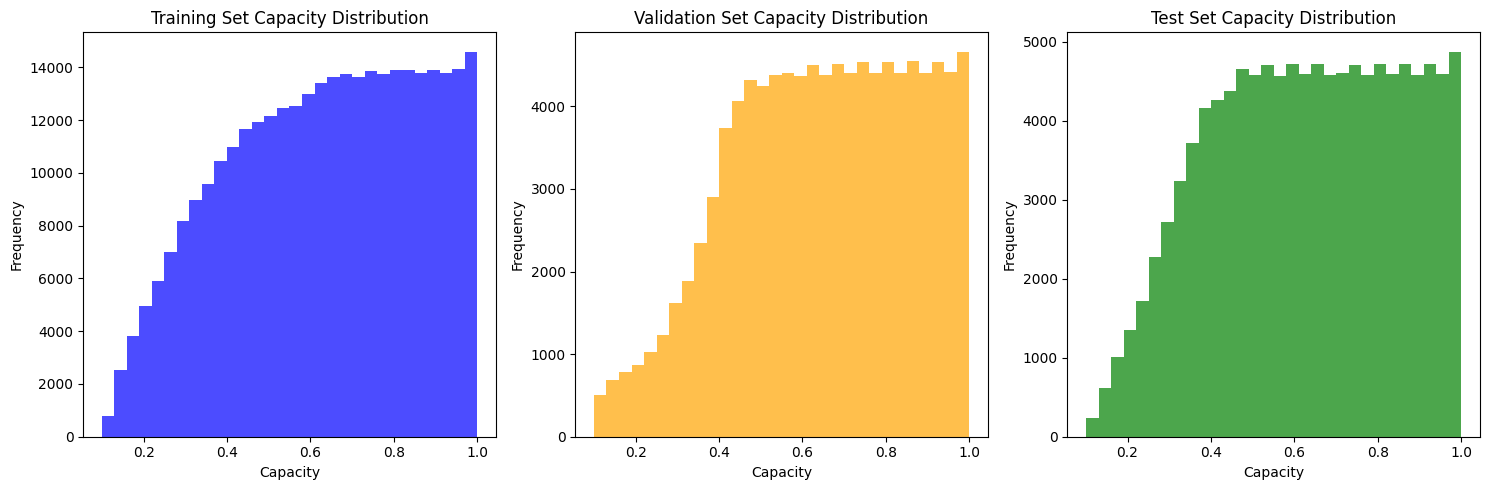

In [3]:
# Display basic statistics about the target variable
print("Target variable (capacity) statistics:")
print(f"Training set - Mean: {np.mean(y_train):.3f}, Std: {np.std(y_train):.3f}")
print(f"Validation set - Mean: {np.mean(y_val):.3f}, Std: {np.std(y_val):.3f}")
print(f"Test set - Mean: {np.mean(y_test):.3f}, Std: {np.std(y_test):.3f}")

# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(y_train, bins=30, alpha=0.7, color='blue')
axes[0].set_title('Training Set Capacity Distribution')
axes[0].set_xlabel('Capacity')
axes[0].set_ylabel('Frequency')

axes[1].hist(y_val, bins=30, alpha=0.7, color='orange')
axes[1].set_title('Validation Set Capacity Distribution')
axes[1].set_xlabel('Capacity')
axes[1].set_ylabel('Frequency')

axes[2].hist(y_test, bins=30, alpha=0.7, color='green')
axes[2].set_title('Test Set Capacity Distribution')
axes[2].set_xlabel('Capacity')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2. Model Training and Evaluation Functions

Define utility functions for model training, prediction, and evaluation.

In [4]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance with multiple metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

def plot_predictions(y_true, y_pred, model_name, dataset_name=''):
    """Plot predicted vs actual values."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    
    # Plot perfect prediction line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Capacity')
    plt.ylabel('Predicted Capacity')
    plt.title(f'{model_name} - Predicted vs Actual {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² score to plot
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, model_name, dataset_name=''):
    """Plot residuals to check for patterns."""
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residuals vs Predicted
    axes[0].scatter(y_pred, residuals, alpha=0.6)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted Capacity')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title(f'{model_name} - Residuals vs Predicted {dataset_name}')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[1].hist(residuals, bins=30, alpha=0.7)
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name} - Residuals Distribution {dataset_name}')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 3. Linear Regression Model

In [5]:
print("Training Linear Regression model...")

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train)
lr_val_pred = lr_model.predict(X_val)
lr_test_pred = lr_model.predict(X_test)

# Evaluate performance
lr_train_metrics = evaluate_model(y_train, lr_train_pred, "Linear Regression (Training)")
lr_val_metrics = evaluate_model(y_val, lr_val_pred, "Linear Regression (Validation)")
lr_test_metrics = evaluate_model(y_test, lr_test_pred, "Linear Regression (Test)")

print("\nLinear Regression training completed.")

Training Linear Regression model...

Linear Regression (Training) Performance:
MSE: 0.000051
RMSE: 0.007137
MAE: 0.000993
R²: 0.999016

Linear Regression (Validation) Performance:
MSE: 0.000015
RMSE: 0.003841
MAE: 0.000809
R²: 0.999680

Linear Regression (Test) Performance:
MSE: 0.000011
RMSE: 0.003287
MAE: 0.001001
R²: 0.999781

Linear Regression training completed.


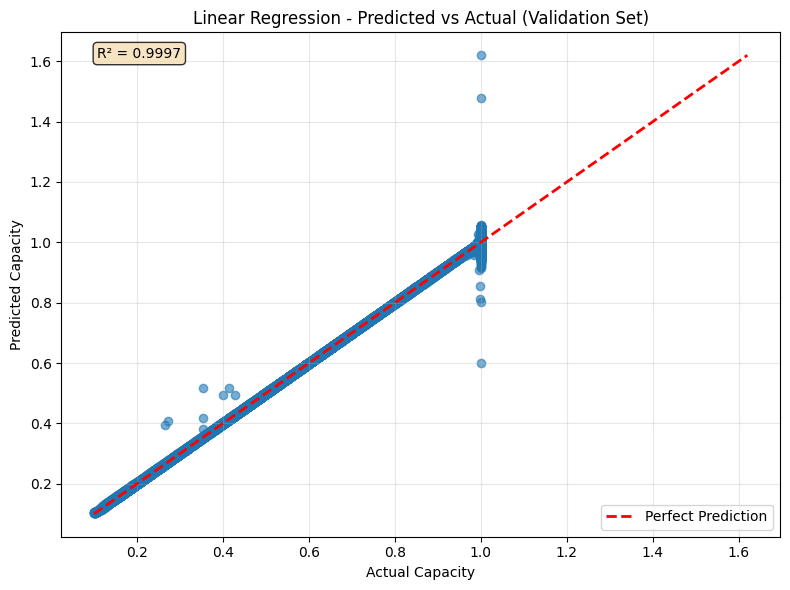

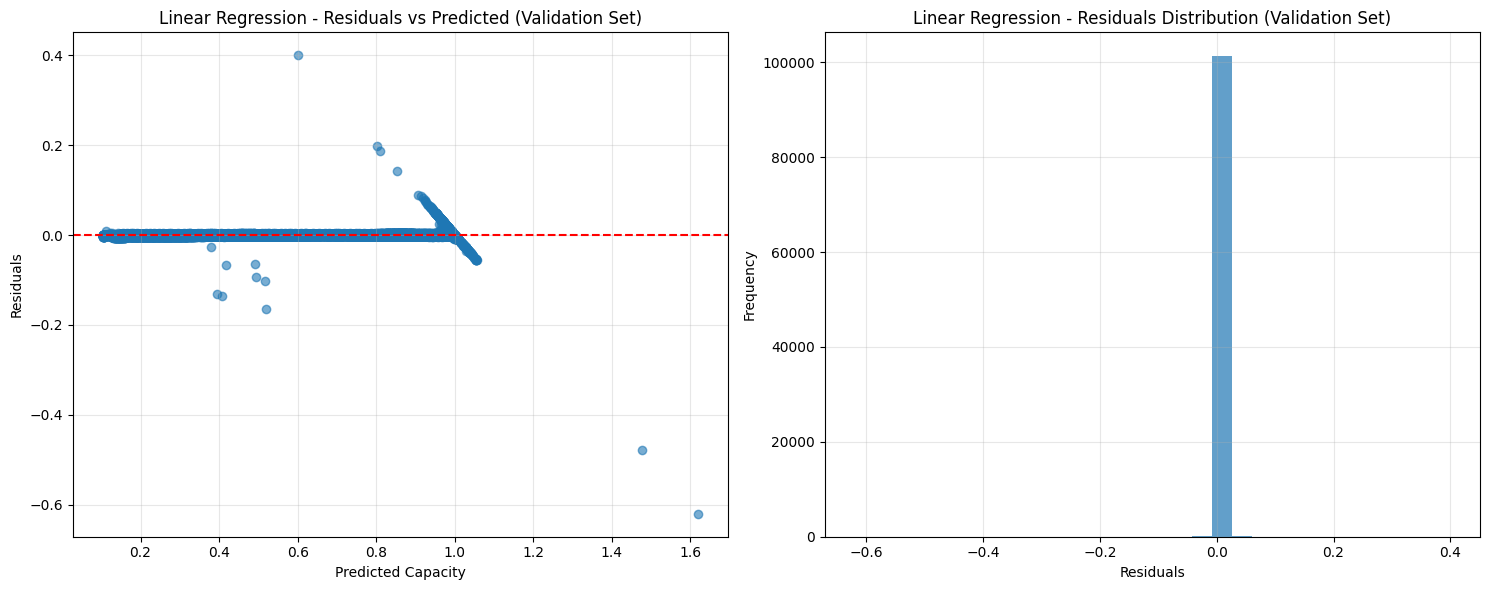

In [6]:
# Visualize Linear Regression results
plot_predictions(y_val, lr_val_pred, "Linear Regression", "(Validation Set)")
plot_residuals(y_val, lr_val_pred, "Linear Regression", "(Validation Set)")

## 4. Random Forest Model

In [7]:
print("Training Random Forest model...")

# Train Random Forest with default parameters first
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test)

# Evaluate performance
rf_train_metrics = evaluate_model(y_train, rf_train_pred, "Random Forest (Training)")
rf_val_metrics = evaluate_model(y_val, rf_val_pred, "Random Forest (Validation)")
rf_test_metrics = evaluate_model(y_test, rf_test_pred, "Random Forest (Test)")

print("\nRandom Forest training completed.")

Training Random Forest model...

Random Forest (Training) Performance:
MSE: 0.000000
RMSE: 0.000479
MAE: 0.000029
R²: 0.999996

Random Forest (Validation) Performance:
MSE: 0.000005
RMSE: 0.002284
MAE: 0.000150
R²: 0.999887

Random Forest (Test) Performance:
MSE: 0.000010
RMSE: 0.003227
MAE: 0.000232
R²: 0.999789

Random Forest training completed.


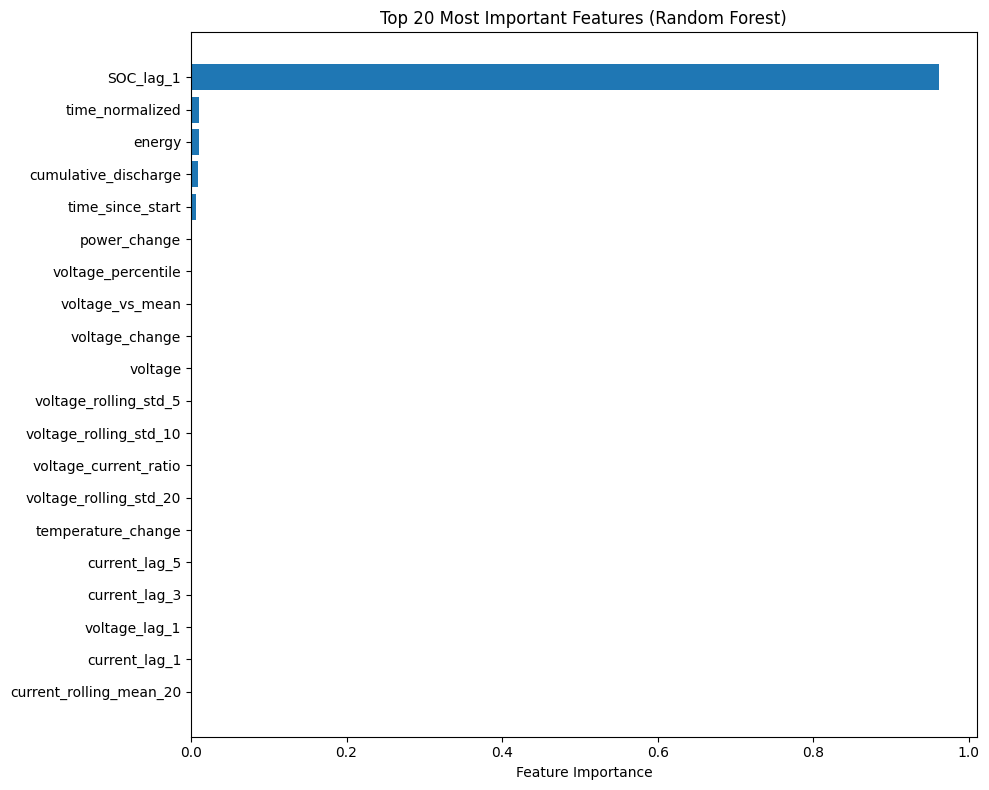


Top 10 most important features:
                 feature  importance
34             SOC_lag_1    0.961881
30       time_normalized    0.010812
8                 energy    0.010119
28  cumulative_discharge    0.008708
31      time_since_start    0.006544
12          power_change    0.000677
43    voltage_percentile    0.000460
41       voltage_vs_mean    0.000259
9         voltage_change    0.000235
0                voltage    0.000180


In [8]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,  # Use the feature_cols loaded from the pickle file
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10))

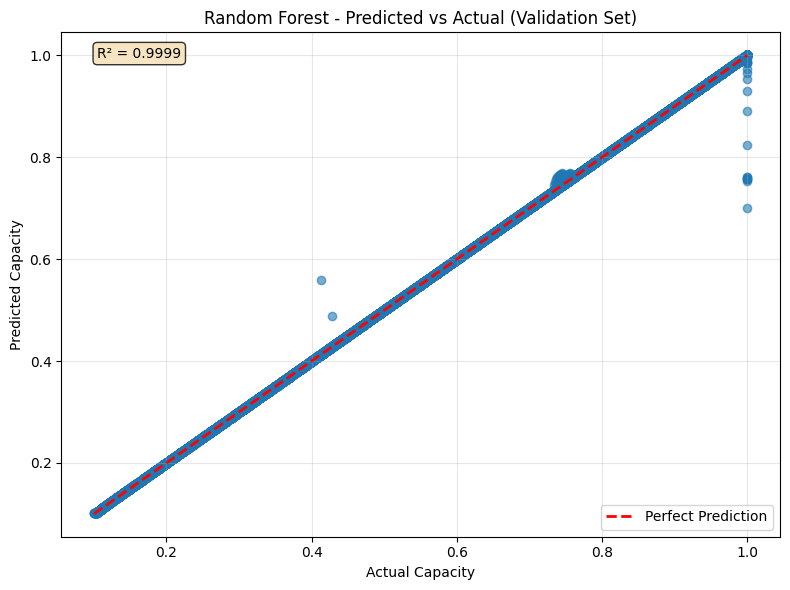

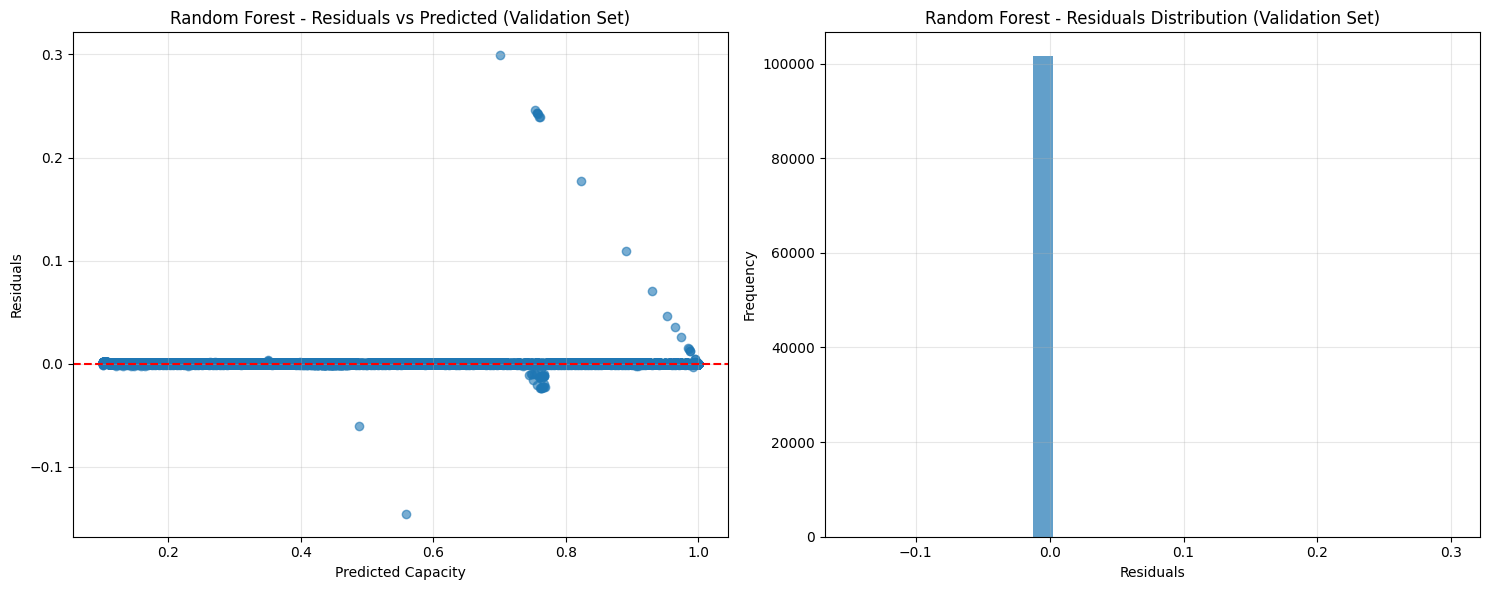

In [9]:
# Visualize Random Forest results
plot_predictions(y_val, rf_val_pred, "Random Forest", "(Validation Set)")
plot_residuals(y_val, rf_val_pred, "Random Forest", "(Validation Set)")

## 5. XGBoost Model

In [10]:
print("Training XGBoost model...")

# Train XGBoost with default parameters first
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate performance
xgb_train_metrics = evaluate_model(y_train, xgb_train_pred, "XGBoost (Training)")
xgb_val_metrics = evaluate_model(y_val, xgb_val_pred, "XGBoost (Validation)")
xgb_test_metrics = evaluate_model(y_test, xgb_test_pred, "XGBoost (Test)")

print("\nXGBoost training completed.")

Training XGBoost model...

XGBoost (Training) Performance:
MSE: 0.000001
RMSE: 0.000968
MAE: 0.000792
R²: 0.999982

XGBoost (Validation) Performance:
MSE: 0.000004
RMSE: 0.002067
MAE: 0.000871
R²: 0.999907

XGBoost (Test) Performance:
MSE: 0.000002
RMSE: 0.001395
MAE: 0.000860
R²: 0.999961

XGBoost training completed.


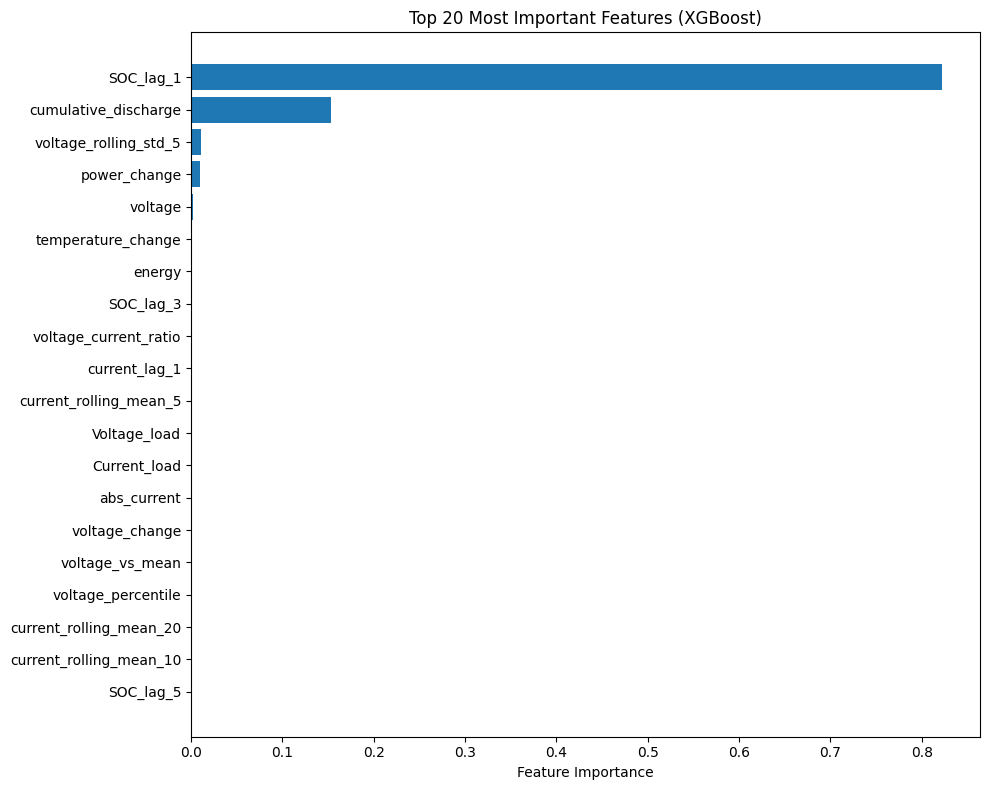


Top 10 most important features (XGBoost):
                  feature  importance
34              SOC_lag_1    0.822583
28   cumulative_discharge    0.152994
16  voltage_rolling_std_5    0.010332
12           power_change    0.009807
0                 voltage    0.002454
11     temperature_change    0.000544
8                  energy    0.000245
37              SOC_lag_3    0.000222
7   voltage_current_ratio    0.000152
33          current_lag_1    0.000099


In [11]:
# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,  # Use the feature_cols loaded from the pickle file
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(10, 8))
top_xgb_features = xgb_importance.head(20)
plt.barh(range(len(top_xgb_features)), top_xgb_features['importance'])
plt.yticks(range(len(top_xgb_features)), top_xgb_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features (XGBoost):")
print(xgb_importance.head(10))

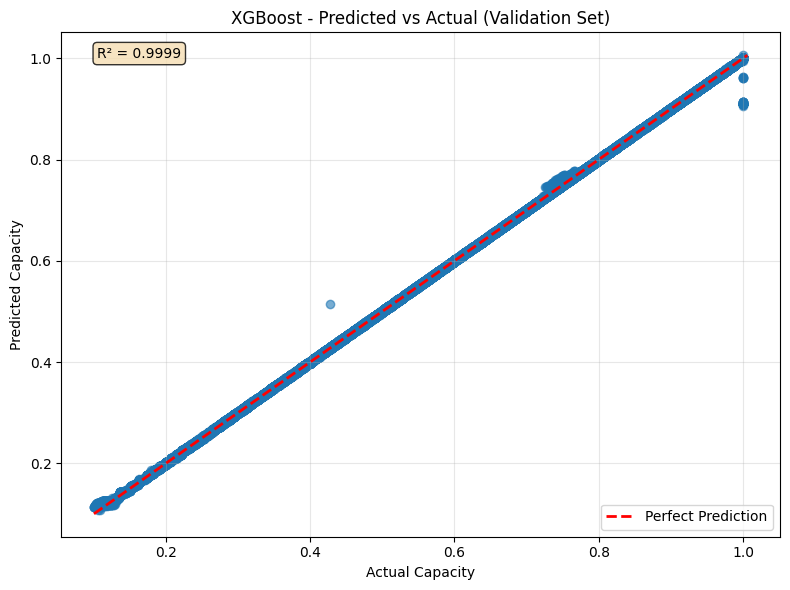

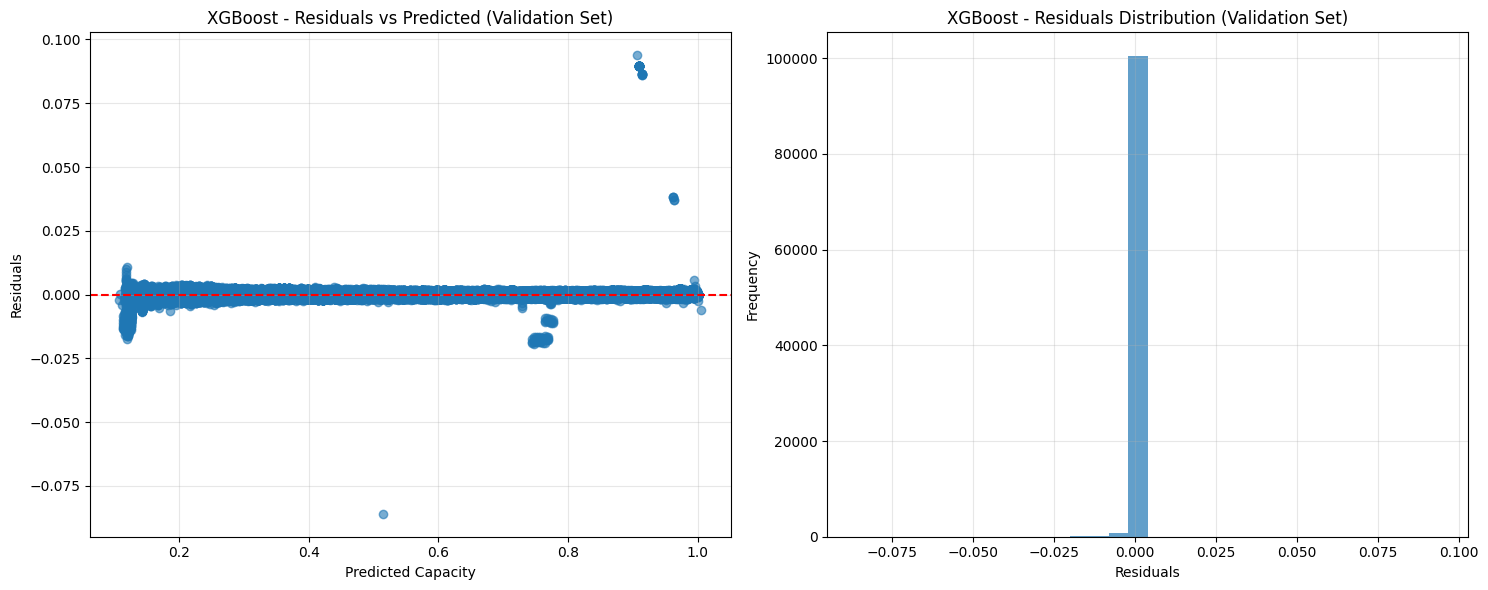

In [12]:
# Visualize XGBoost results
plot_predictions(y_val, xgb_val_pred, "XGBoost", "(Validation Set)")
plot_residuals(y_val, xgb_val_pred, "XGBoost", "(Validation Set)")

## 6. Model Comparison

In [13]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Training_R2': [lr_train_metrics['r2'], rf_train_metrics['r2'], xgb_train_metrics['r2']],
    'Training_RMSE': [lr_train_metrics['rmse'], rf_train_metrics['rmse'], xgb_train_metrics['rmse']],
    'Validation_R2': [lr_val_metrics['r2'], rf_val_metrics['r2'], xgb_val_metrics['r2']],
    'Validation_RMSE': [lr_val_metrics['rmse'], rf_val_metrics['rmse'], xgb_val_metrics['rmse']],
    'Test_R2': [lr_test_metrics['r2'], rf_test_metrics['r2'], xgb_test_metrics['r2']],
    'Test_RMSE': [lr_test_metrics['rmse'], rf_test_metrics['rmse'], xgb_test_metrics['rmse']]
})

print("Model Performance Comparison:")
print(results_df.round(6))

Model Performance Comparison:
               Model  Training_R2  Training_RMSE  Validation_R2  \
0  Linear Regression     0.999016       0.007137       0.999680   
1      Random Forest     0.999996       0.000479       0.999887   
2            XGBoost     0.999982       0.000968       0.999907   

   Validation_RMSE   Test_R2  Test_RMSE  
0         0.003841  0.999781   0.003287  
1         0.002284  0.999789   0.003227  
2         0.002067  0.999961   0.001395  


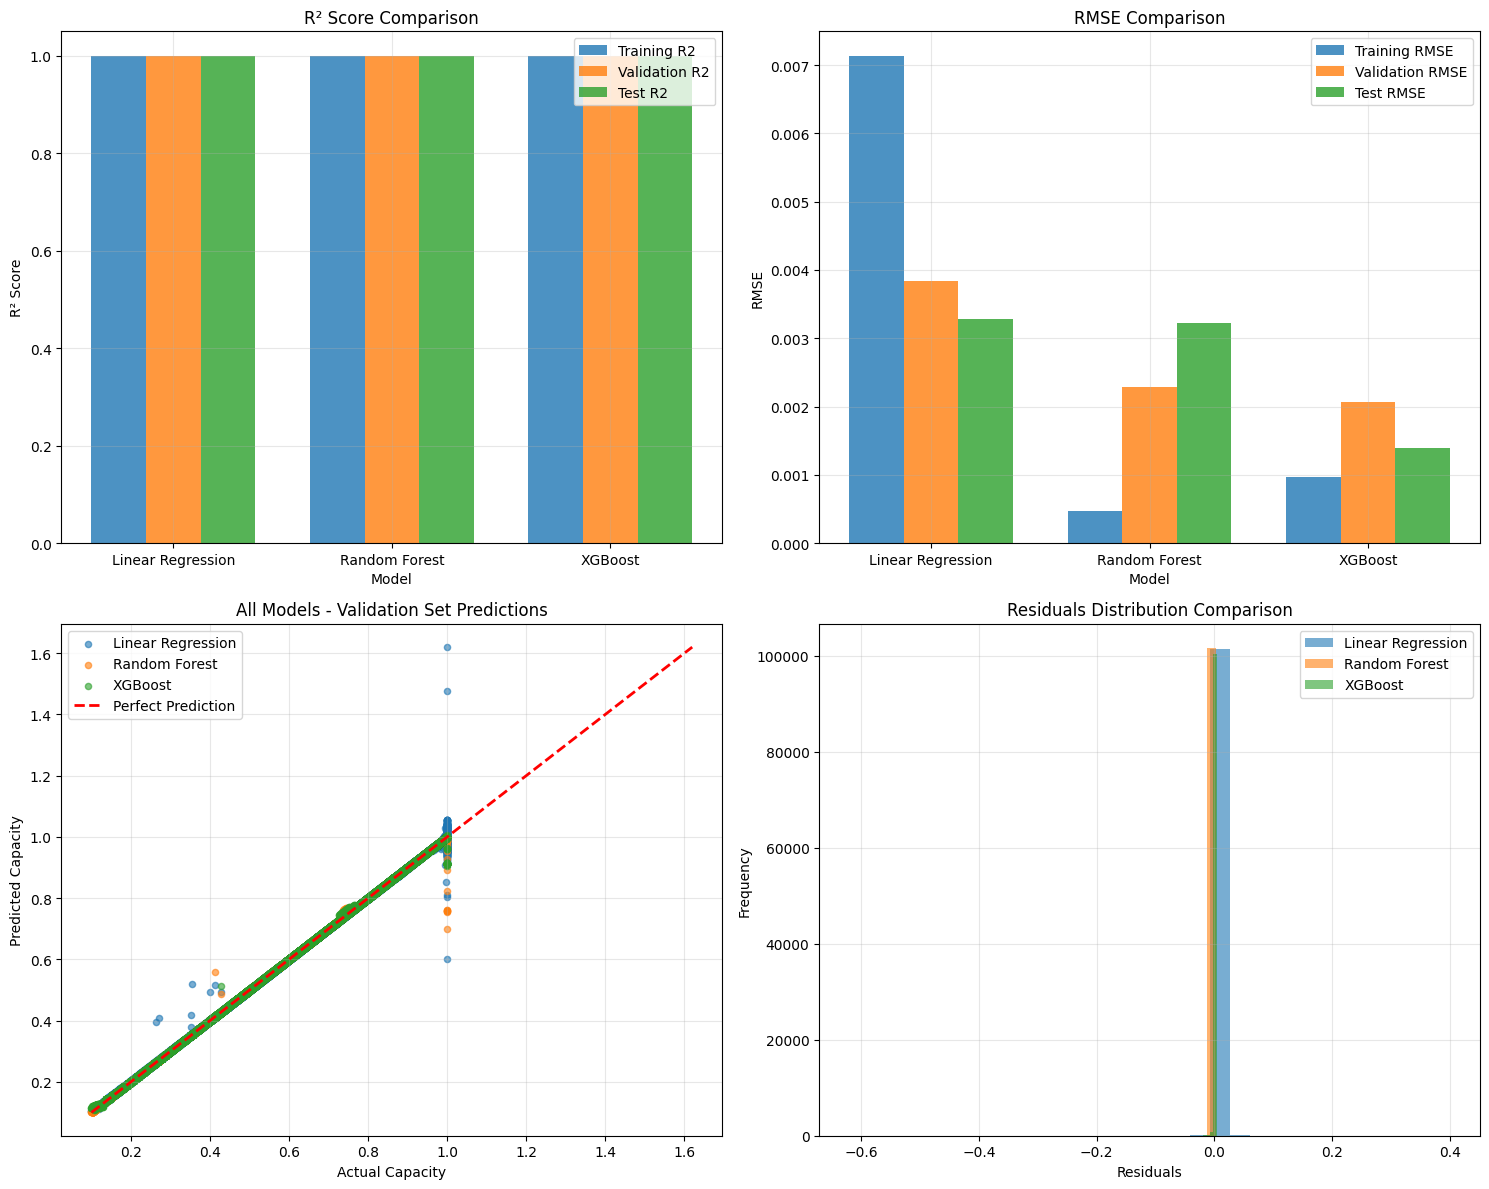

In [14]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² comparison
metrics = ['Training_R2', 'Validation_R2', 'Test_R2']
x_pos = np.arange(len(results_df))
width = 0.25

for i, metric in enumerate(metrics):
    axes[0, 0].bar(x_pos + i*width, results_df[metric], width, 
                   label=metric.replace('_', ' '), alpha=0.8)

axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x_pos + width)
axes[0, 0].set_xticklabels(results_df['Model'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE comparison
rmse_metrics = ['Training_RMSE', 'Validation_RMSE', 'Test_RMSE']
for i, metric in enumerate(rmse_metrics):
    axes[0, 1].bar(x_pos + i*width, results_df[metric], width, 
                   label=metric.replace('_', ' '), alpha=0.8)

axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE Comparison')
axes[0, 1].set_xticks(x_pos + width)
axes[0, 1].set_xticklabels(results_df['Model'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Prediction comparison on validation set
axes[1, 0].scatter(y_val, lr_val_pred, alpha=0.6, label='Linear Regression', s=20)
axes[1, 0].scatter(y_val, rf_val_pred, alpha=0.6, label='Random Forest', s=20)
axes[1, 0].scatter(y_val, xgb_val_pred, alpha=0.6, label='XGBoost', s=20)

min_val = min(y_val.min(), lr_val_pred.min(), rf_val_pred.min(), xgb_val_pred.min())
max_val = max(y_val.max(), lr_val_pred.max(), rf_val_pred.max(), xgb_val_pred.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

axes[1, 0].set_xlabel('Actual Capacity')
axes[1, 0].set_ylabel('Predicted Capacity')
axes[1, 0].set_title('All Models - Validation Set Predictions')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residuals comparison
lr_residuals = y_val - lr_val_pred
rf_residuals = y_val - rf_val_pred
xgb_residuals = y_val - xgb_val_pred

axes[1, 1].hist(lr_residuals, alpha=0.6, label='Linear Regression', bins=30)
axes[1, 1].hist(rf_residuals, alpha=0.6, label='Random Forest', bins=30)
axes[1, 1].hist(xgb_residuals, alpha=0.6, label='XGBoost', bins=30)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residuals Distribution Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Final Model Evaluation on Test Set

Evaluate the best performing model on the test set for final performance assessment.

Best performing model: XGBoost
Validation R²: 0.999907
Test R²: 0.999961

Final Test Set Evaluation - XGBoost:

XGBoost Performance:
MSE: 0.000002
RMSE: 0.001395
MAE: 0.000860
R²: 0.999961


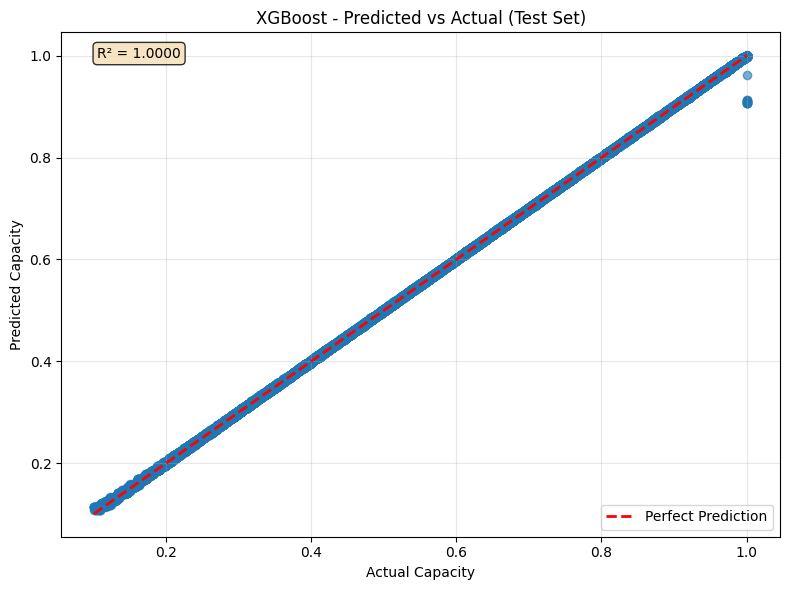

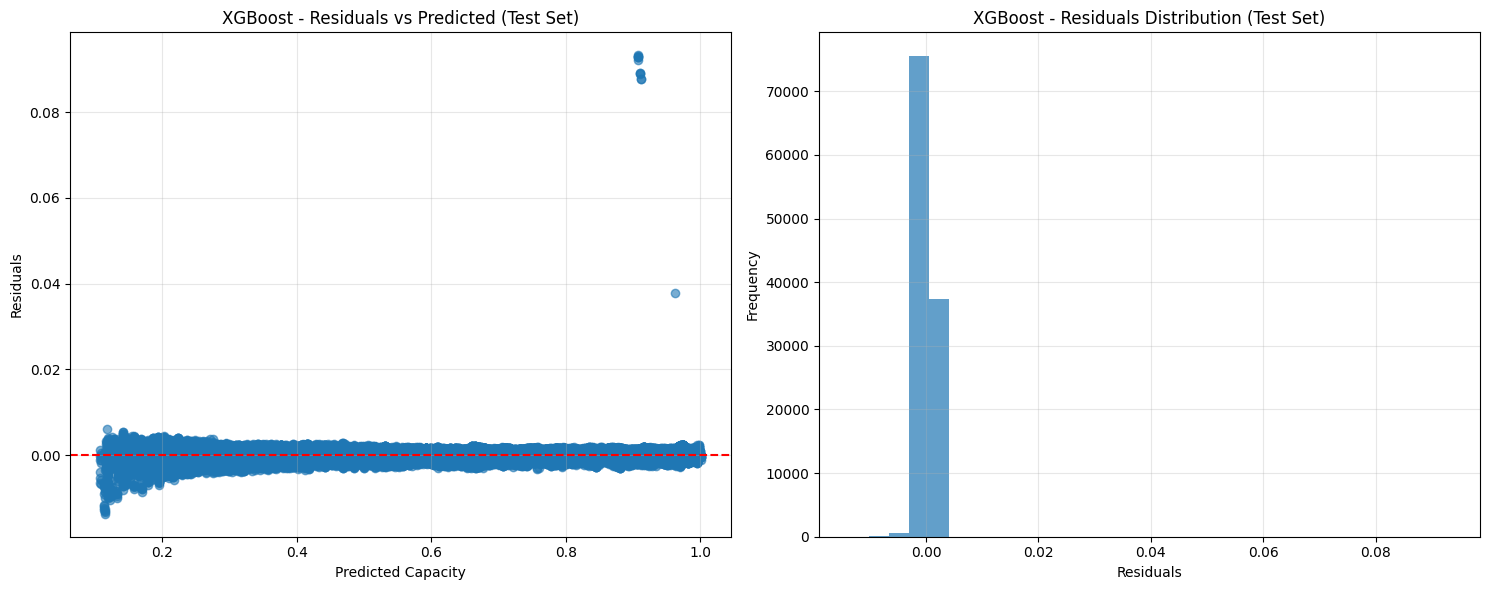

In [15]:
# Identify best model based on validation R²
best_model_idx = results_df['Validation_R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_val_r2 = results_df.loc[best_model_idx, 'Validation_R2']
best_test_r2 = results_df.loc[best_model_idx, 'Test_R2']

print(f"Best performing model: {best_model_name}")
print(f"Validation R²: {best_val_r2:.6f}")
print(f"Test R²: {best_test_r2:.6f}")

# Get predictions from best model
if best_model_name == 'Linear Regression':
    best_test_pred = lr_test_pred
elif best_model_name == 'Random Forest':
    best_test_pred = rf_test_pred
else:  # XGBoost
    best_test_pred = xgb_test_pred

# Final test set evaluation
print(f"\nFinal Test Set Evaluation - {best_model_name}:")
final_metrics = evaluate_model(y_test, best_test_pred, best_model_name)

# Plot final results
plot_predictions(y_test, best_test_pred, best_model_name, "(Test Set)")
plot_residuals(y_test, best_test_pred, best_model_name, "(Test Set)")

## 8. Model Summary and Recommendations

Summary of model performance and recommendations for deployment.

In [16]:
print("=" * 60)
print("MODEL TRAINING SUMMARY")
print("=" * 60)

print("\nModels Trained:")
print("1. Linear Regression - Simple baseline model")
print("2. Random Forest - Ensemble method with feature importance")
print("3. XGBoost - Gradient boosting with regularization")

print("\nDataset Information:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

print("\nPerformance Summary (Test Set R²):")
for idx, row in results_df.iterrows():
    print(f"{row['Model']}: {row['Test_R2']:.6f}")

print(f"\nBest Model: {best_model_name}")
print(f"Test Set R²: {best_test_r2:.6f}")
print(f"Test Set RMSE: {results_df.loc[best_model_idx, 'Test_RMSE']:.6f}")

# Check for overfitting
print("\nOverfitting Analysis:")
for idx, row in results_df.iterrows():
    train_r2 = row['Training_R2']
    val_r2 = row['Validation_R2']
    gap = train_r2 - val_r2
    print(f"{row['Model']}: Training R² = {train_r2:.4f}, Validation R² = {val_r2:.4f}, Gap = {gap:.4f}")
    
    if gap > 0.1:
        print(f"  WARNING: {row['Model']} shows signs of overfitting (gap > 0.1)")
    elif gap > 0.05:
        print(f"  CAUTION: {row['Model']} shows mild overfitting (gap > 0.05)")
    else:
        print(f"  GOOD: {row['Model']} shows good generalization")

print("\n" + "=" * 60)
print("RECOMMENDATIONS")
print("=" * 60)

print(f"\n1. Deploy {best_model_name} for production use")
print("2. Monitor model performance on new data")
print("3. Consider hyperparameter tuning for further improvements")
print("4. Implement feature selection to reduce model complexity")
print("5. Consider ensemble methods combining multiple models")

if best_model_name != 'Linear Regression':
    print(f"6. Use feature importance from {best_model_name} for feature engineering")

print("\nModel training completed successfully!")

MODEL TRAINING SUMMARY

Models Trained:
1. Linear Regression - Simple baseline model
2. Random Forest - Ensemble method with feature importance
3. XGBoost - Gradient boosting with regularization

Dataset Information:
Training samples: 326540
Validation samples: 101570
Test samples: 113400
Features: 45

Performance Summary (Test Set R²):
Linear Regression: 0.999781
Random Forest: 0.999789
XGBoost: 0.999961

Best Model: XGBoost
Test Set R²: 0.999961
Test Set RMSE: 0.001395

Overfitting Analysis:
Linear Regression: Training R² = 0.9990, Validation R² = 0.9997, Gap = -0.0007
  GOOD: Linear Regression shows good generalization
Random Forest: Training R² = 1.0000, Validation R² = 0.9999, Gap = 0.0001
  GOOD: Random Forest shows good generalization
XGBoost: Training R² = 1.0000, Validation R² = 0.9999, Gap = 0.0001
  GOOD: XGBoost shows good generalization

RECOMMENDATIONS

1. Deploy XGBoost for production use
2. Monitor model performance on new data
3. Consider hyperparameter tuning for furt